IMPORT LIBRARIES

In [1]:
import numpy as np
import copy
import random
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import GraphData as sgl
from subroutines_imagenes_microscopio import *

LOAD DATA, PREPARE SHAPE AND NORMALIZED

In [2]:
# Read the data 
f = open("data_imagenes_recortadas.bin","rb")
np_subimagenes = np.load(f)
np_sublabels = np.load(f)
np_index = np.load(f)
f.close()

# Choose only the first image (4096 subimages)
subimages = np.zeros((4096, 64, 64))
sublabels = np.zeros((4096,))
index = np.zeros((4096,))
for i in range (4096):
    subimages[i] = np_subimagenes[i]
    sublabels[i] = np_sublabels[i]
    index[i] = np_index[i]

# Dimension of the data 
number_of_images, width, height = subimages.shape
print(subimages.shape)
print(index.shape)

# Setting maximum value of the pixel = 1 
maximum = subimages.max()
subimages = subimages / maximum

mean = subimages.mean() 
std = subimages.flatten().std()

strech_factor = 5
subimages = strech_factor * (subimages - mean + strech_factor * std)


(4096, 64, 64)
(4096,)


PARAMETERS FOR THE CALCULATION

In [3]:
# Paremeter for decide if we want to run or load the network
run_NeuralNetwork = True

# Parameters that control the calculation
train_ratio = 0.89
val_ratio = 0.1
test_ratio = 0.01

SPLIT TRAINING, VALIDATION AND TEST DATA

In [4]:
# Creating the training, validation and test sets 
x_train, x_val, x_test, y_val, y_train, y_test =\
    split_train_val_test(subimages, index, train_ratio, val_ratio, test_ratio)
    
ntrain, nval, ntest = x_train.shape[0], x_val.shape[0], x_test.shape[0]

# Reshape each image to the input shape
input_channels = 1 #Fake colour
x_train_conv2D = x_train.reshape((ntrain, width, height, input_channels))
x_val_conv2D = x_val.reshape((nval, width, height, input_channels))
x_test_conv2D = x_test.reshape((ntest, width, height, input_channels))

img_cols = x_train_conv2D.shape[1]
img_rows = x_train_conv2D.shape[2]
input_shape = (img_cols, img_rows, input_channels)

print(x_train.shape)

(3645, 64, 64)


AUTOENCODER

In [8]:
# creating the autoencoder
npoints_out = x_train.shape[1]*x_train.shape[2]

# Build the model

batch_size = 64
epochs = 50
#kernel_init = 'random_normal'
#kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=0)
#bias_init = tf.keras.initializers.Constant(0.05)

#Define the model
model = tf.keras.models.Sequential([\
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), padding = 'same', activation = tf.keras.layers.LeakyReLU(), input_shape = input_shape),\
    tf.keras.layers.MaxPooling2D((2,2)),\
    tf.keras.layers.Conv2D(16, (3, 3), padding = 'same', activation = tf.keras.layers.LeakyReLU()),\
    tf.keras.layers.MaxPooling2D((2,2)),\
    tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = tf.keras.layers.LeakyReLU()),\
    tf.keras.layers.MaxPooling2D((2,2)),\
    tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = tf.keras.layers.LeakyReLU()),\
    tf.keras.layers.Flatten(),\
    tf.keras.layers.Dense(npoints_out, activation = 'sigmoid'),\
    tf.keras.layers.Reshape((64, 64, 1))
    ])
model.summary()

loss_function = 'mse'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001, epsilon= 1e-8)

model.compile(optimizer=opt, loss=loss_function, metrics=[tf.keras.metrics.RootMeanSquaredError()])

if (run_NeuralNetwork):
    # Fitting the model
    history = model.fit(x_train_conv2D, x_train_conv2D,
                  batch_size = batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val_conv2D, x_val_conv2D))
    
    #Guardo la history en un array
    evolution_loss = np.zeros((len(history.history['loss'])))
    evolution_rmse = np.zeros((len(history.history['root_mean_squared_error'])))
    evolution_val_loss = np.zeros((len(history.history['val_loss'])))
    evolution_val_rmse = np.zeros((len(history.history['val_root_mean_squared_error'])))
    
    evolution_loss = history.history['loss']
    evolution_rmse = history.history['root_mean_squared_error']
    evolution_val_loss = history.history['val_loss']
    evolution_val_rmse = history.history['val_root_mean_squared_error']
    
    #Escribe los datos del entrenamiento en un fichero
    f = open("C:/Users/PORTATIL/Desktop/TFG/Prueba Convolucional/loss_evolution_model_conv2.bin", "wb")
    np.save(f, evolution_loss)
    np.save(f, evolution_rmse)
    np.save(f, evolution_val_loss)
    np.save(f, evolution_val_rmse)
    f.close()
    
    #saving the model
    model.save('C:/Users/PORTATIL/Desktop/TFG/Prueba Convolucional/model_conv2')
else:
    # Load the model
    model = tf.keras.models.load_model('model1_conv')
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)        

INFO:tensorflow:Assets written to: C:/Users/PORTATIL/Desktop/TFG/Prueba Convolucional/model_conv2\assets


INFO:tensorflow:Assets written to: C:/Users/PORTATIL/Desktop/TFG/Prueba Convolucional/model_conv2\assets


PLOTTING THE RESULTS: MODEL SUMMARY, SCORE AND PERFORMANCE

In [9]:
# Evaluating how good the model is
score_train = model.evaluate(x_train_conv2D, x_train_conv2D, verbose=0)
score_val = model.evaluate(x_val_conv2D, x_val_conv2D, verbose=0)
score_test = model.evaluate(x_test_conv2D, x_test_conv2D, verbose=0)
print('Training loss: ', score_train[0])
print('Training rmse: ', score_train[1])
print('Val loss: ', score_val[0])
print('Val rmse: ', score_val[1])
print('Test loss: ', score_test[0])
print('Test rmse: ', score_test[1])


# Predictions
x_predict_train= model.predict(x_train_conv2D)
x_predict_val= model.predict(x_val_conv2D)
x_predict_test= model.predict(x_test_conv2D)

images_train = x_train_conv2D.reshape((ntrain, width, height))
images_val = x_val_conv2D.reshape((nval, width, height))
images_test = x_test_conv2D.reshape((ntest, width, height))

images_predict_train = x_predict_train.reshape((ntrain, width, height))
images_predict_val = x_predict_val.reshape((nval, width, height))
images_predict_test = x_predict_test.reshape((ntest, width, height))

#Reordeno los recortes con sus respectivos índices y los guardo en un fichero
images_predict = np.concatenate((images_predict_train, images_predict_val, images_predict_test))
image_original = np.concatenate((images_train, images_val, images_test))
y = np.concatenate((y_train, y_val, y_test))

ref = np.zeros((images_predict.shape[0], images_predict.shape[1], images_predict.shape[2]))
print(ref.shape)
for i in range (len(y)):
    min = i
    for j in range (len(y)):
        if int(y[j]) == min:

            minim = y[j]
            ref[j] = images_predict[j]

            y[j] = y[i]
            images_predict[j] = images_predict[i]

            y[i] = minim
            images_predict[i] = ref[j]

filtered_images = images_predict[:,:,:]
labels_ordened = y[:]

f = open("C:/Users/PORTATIL/Desktop/TFG/Prueba Convolucional/data_filtered_reordened_images_model_conv2.bin", "wb")
np.save(f, filtered_images)
np.save(f, labels_ordened)
f.close()

Training loss:  0.0069891344755887985
Training rmse:  0.08360104262828827
Val loss:  0.007199947256594896
Val rmse:  0.08485250174999237
Test loss:  0.007148842792958021
Test rmse:  0.08455082774162292
2/2 [==============================] - 1s 14ms/step
(4096, 64, 64)


RECONSTRUCTION OF THE IMAGES

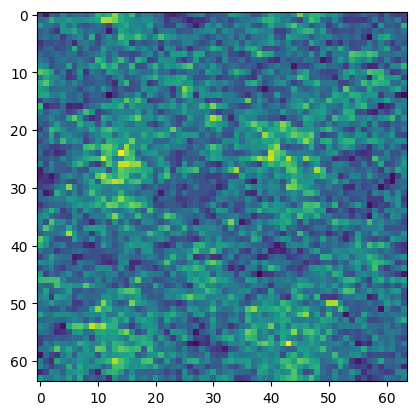

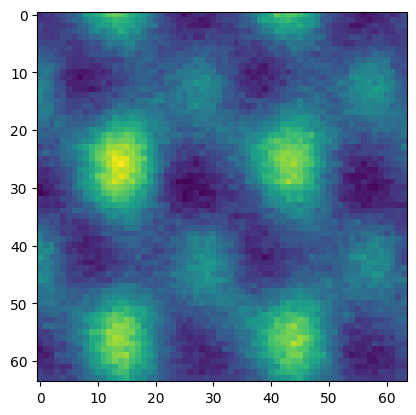

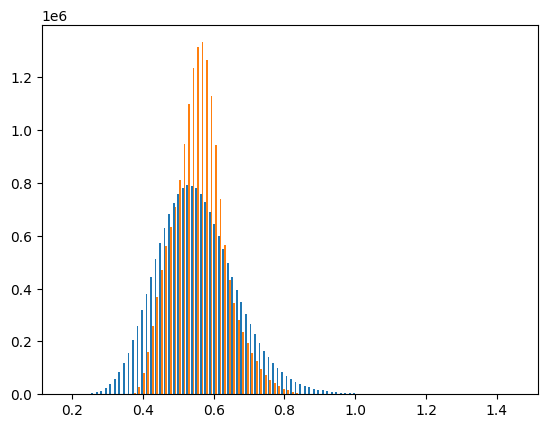

In [10]:
#if(run_NeuralNetwork):
#    plot_score("C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Data_Loss" , history)
#    
#    n_epochs = np.arange(len(history.history['loss']))
#    sgl.GraphData([[n_epochs, history.history['loss']],
#                [n_epochs,  history.history['val_loss']]],['r', 'b'], 
#                ['Train', 'Validation'],'','C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Loss_model_conv2.png', Axx='$Epochs$', Axy='$Loss$')

# Showing some results
ind = 0
plt.imshow(subimages[ind])
#plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Original_test_model_conv2.png', bbox_inches='tight')
plt.show()
plt.imshow(images_predict[ind])
#plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Reduced_test_model_conv2.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
plt.show()
plt.hist([subimages.flatten(), images_predict.flatten()], bins=100)
#plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Histogram_test_model_conv2.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
plt.show()
#plot_one_image_and_prediction(subimages[ind], images_predict[ind])
#plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Conv/Comparison_test_model_conv2.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
#plt.show()